In [1]:
import os
import shutil
import traceback

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import panoramafunc
import plots

from skimage import io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pano_image_collection = io.ImageCollection(f"images/*",load_func=lambda f: io.imread(f).astype(np.float64) / 255)


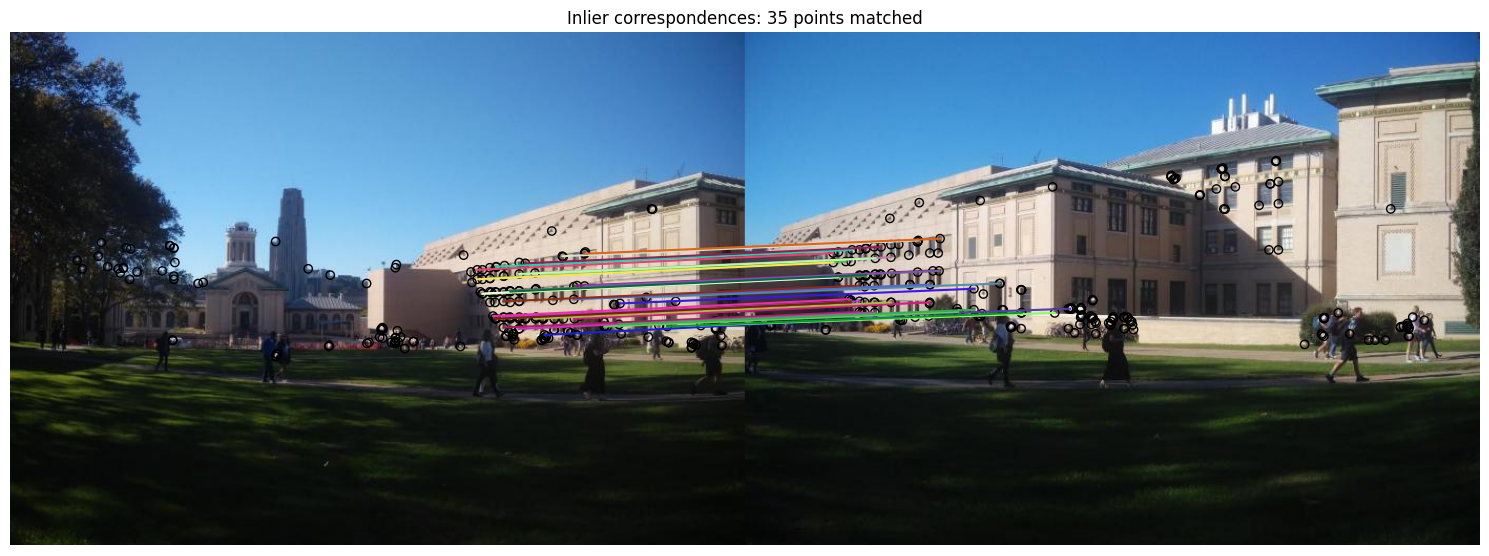

In [5]:
# ------------------------------------------------------------------------------------------
# example with 2 images descriptors
# ------------------------------------------------------------------------------------------

src, dest = pano_image_collection[0], pano_image_collection[1]
src_keypoints, src_descriptors = panoramafunc.find_keypoints(src)
dest_keypoints, dest_descriptors = panoramafunc.find_keypoints(dest)

robust_transform, matches = panoramafunc.ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)

plots.plot_inliers(src, dest, src_keypoints, dest_keypoints, matches, streamlit = False)

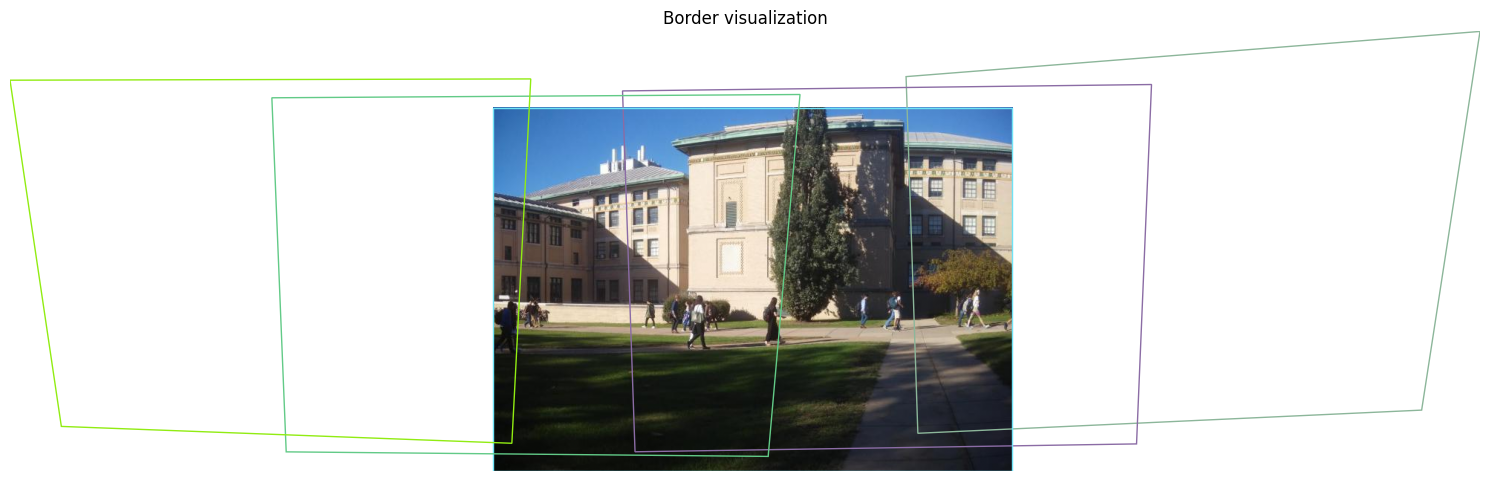

In [7]:
# ------------------------------------------------------------------------------------------
# point and descriptors for all images pairs
# ------------------------------------------------------------------------------------------

keypoints, descriptors = zip(*(panoramafunc.find_keypoints(img) for img in pano_image_collection))

forward_transforms = tuple(panoramafunc.ransac_transform(sorc_kp, src_desc, dest_kp, dest_desc)
                            for sorc_kp, src_desc, dest_kp, dest_desc
                            in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))

# ------------------------------------------------------------------------------------------
# Merge and find borders
# ------------------------------------------------------------------------------------------    



simple_center_warps = panoramafunc.find_center_warps(forward_transforms)
corners = np.flip(tuple(panoramafunc.get_corners(pano_image_collection, simple_center_warps)), axis= None)
min_coords, max_coords = panoramafunc.get_min_max_coords(corners)
central_img = pano_image_collection[ (len(pano_image_collection) - 1) // 2]

plots.plot_warps(corners, min_coords=min_coords, max_coords=max_coords, img=central_img, streamlit = False)

In [8]:
# ------------------------------------------------------------------------------------------
# Get final wrap
# ------------------------------------------------------------------------------------------

final_central_warps, output_shape = panoramafunc.get_final_center_warps(pano_image_collection, simple_center_warps)
corners = np.flip(tuple(panoramafunc.get_corners(pano_image_collection, final_central_warps)), axis= None)


result_pano = panoramafunc.merge_final_pano(pano_image_collection, final_central_warps, output_shape)

plots.plot_result(result_pano)

In [21]:
# ------------------------------------------------------------------------------------------
# Get smoothed pano
# ------------------------------------------------------------------------------------------

img = pano_image_collection[0]

lap_pyramid = panoramafunc.get_laplacian_pyramid(img)
img_ret = sum(lap_pyramid)

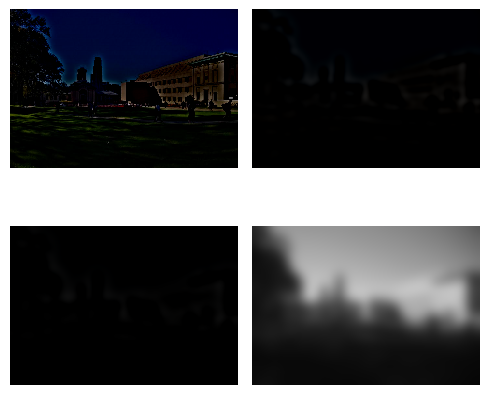

In [23]:
    
fig = plt.figure(figsize=(5,5))

for i in range(1, 2 * 2 + 1):
    fig.add_subplot(2, 2, i)

    img = lap_pyramid[i-1].clip(0,1)

    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

plt.tight_layout()
plt.show()

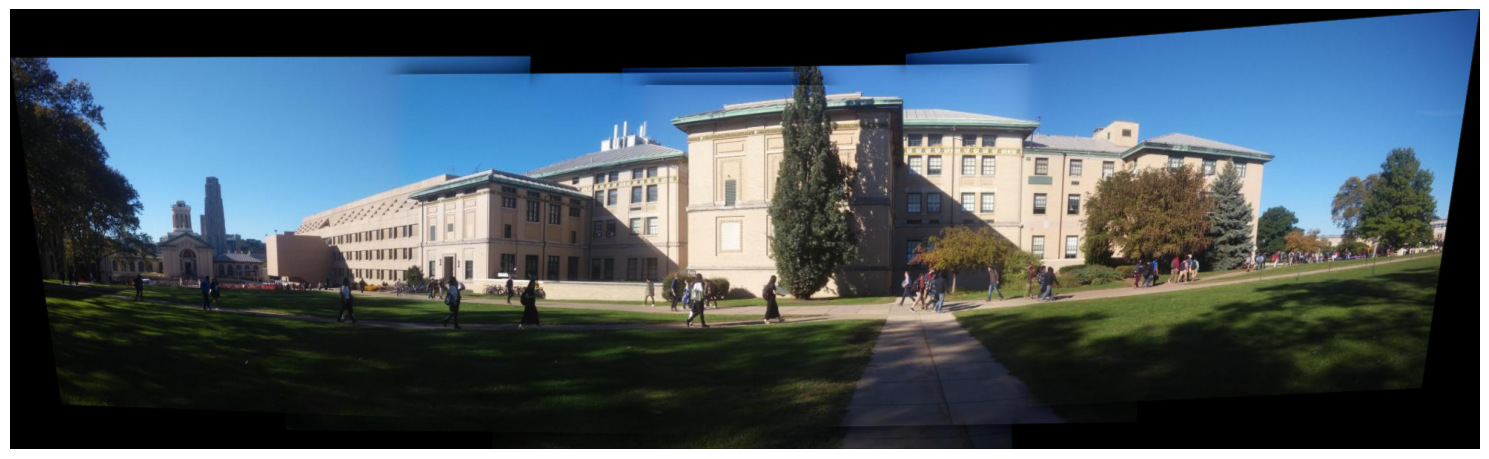

In [10]:
# ------------------------------------------------------------------------------------------
# Get smoothed pano
# ------------------------------------------------------------------------------------------

img = pano_image_collection[0]

result_pano_smth = panoramafunc.gaussian_merging_pano(pano_image_collection, final_central_warps, output_shape)

plots.plot_result(result_pano_smth, streamlit = False)